<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

# 2.5.2 Copernicus Sentinel-3 SLSTR NRT - Fire Radiative Power (FRP) - Level 2

**Run the tutorial via free cloud platforms**: 
[![wekeo](https://img.shields.io/badge/launch-WEKEO-1a4696.svg)](https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/90_workshops/202409_ac_training/WEkEO_how_to_start.pdf)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/2024-cams-act6-training/blob/main/01-satellite/supporting_material/1_Sentinel-3_SLSTR_NRT_FRP_L2_load_browse.ipynb)
[![eumetlab](https://img.shields.io/badge/open-EUMETLAB-E67E22.svg)](https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/90_workshops/202409_ac_training?ref_type=heads)

The [Copernicus Sentinel-3 SLSTR Near-Real-Time Fire Radiative Power (FRP)](https://navigator.eumetsat.int/product/EO:EUM:DAT:0207) product identifies the location and quantifies the radiative power of any hotspot present on land and ocean, that radiates a heating signal within a pixel size of 1 km<sup>2</sup>.

All threatening hotspots are identified and characterised within three hours from SLSTR observation sensing time.
The current version of the Near-Real-Time (NRT) S3 FRP processor is mainly applicable during the night while only a few daytime granules, with non-saturated background (i.e. no fires) radiance, are processed at this stage. The NRT S3 FRP product will become operational after a higher level of quality and maturity is reached, including the full processing of granules during daytime, a comprehensive global validation, and positive feedback by experts and users.

The notebook shows an example of the Greek Fires in August 2023.

#### This module has the following outline:
* [1 - Load Sentinel-3 SLSTR NRT FRP data](#load_s3_frp)
* [2 - Load, mask and regrid NRT FRP computed from MWIR channel (3.7 um)](#load_mwir)
* [3 - Load, mask and regrid NRT FRP computed from SWIR channel (2.25 um)](#load_swir)
* [4 - Load, mask and regrid NRT FRP computed from SWIR channel (2.25 um) with SAA filter applied](#load_swir_nosaa)

#### Load required libraries

In [1]:
import sys
!{sys.executable} -m pip install cartopy netCDF4 h5netcdf==1.3.0

In [2]:
import xarray as xr
import requests
import io

import os
os.environ['PROJ_LIB'] = '/opt/conda/share/proj'

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import tempfile

#### Load helper functions (change the path based on the environment)

In [3]:
if os.path.exists("helper_functions.ipynb"):
    %run helper_functions.ipynb
elif os.path.exists("../helper_functions.ipynb"):
    %run ../helper_functions.ipynb
else:
    print("Helper functions notebook not found in any specified path. Downloading from Gitlab.")    
    !wget https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/raw/master/90_workshops/202409_ac_training/helper_functions.ipynb
    %run helper_functions.ipynb

#### Set variables

In [4]:
base_url = "https://s3.waw3-2.cloudferro.com/swift/v1/act6/"

latmin = 30
latmax = 50
lonmin = 15
lonmax = 40

<hr>

## <a id='load_s3_frp'></a>Load Sentinel-3 SLSTR Near-Real-Time FRP data

Sentinel-3 SLSTR NRT FRP data are disseminated  in `netCDF` format. The first step is to load the data file with xarray's `xr.open_dataset()` function.


Once the data file is loaded, you see that the data file has three dimensions: `columns`, `fires` and `rows`. The data and additional information, such as quality flags or latitude and longitude information, is stored as data variables.

There are 2 variables of interest:
- `FRP_MWIR` - Fire Radiative Power computed from MWIR channel (3.7 um) [MW]
- `FRP_SWIR` - Fire Radiative Power computed from SWIR channel (2.25 um) [MW]

The channels differ in the type of fire they can detect. The `FRP_MWIR` channel detects less intensive fires with a temperature lower than 1100 Kelvin, whereas the `FRP_SWIR` channel detects fires with higher temperatures (>1100 Kelvin).

In [5]:
# Define the data path
data_path = "data/s3/frp/S3A_SL_2_FRP____20230822T091312_20230822T091612_20240820T220534_0179_102_264______MAR_D_NR_003.SEN3/"
filename = "FRP_Merged_MWIR1kmStandard_SWIR1km.nc"

# Stream the file content
response = requests.get(base_url + data_path + filename, stream=True)

# Ensure the request is successful
if response.status_code == 200:
    # Convert the streamed content into a file-like object
    file_obj = io.BytesIO(response.content)
    # Write to a temporary file and open it using the netcdf4 engine
    with tempfile.NamedTemporaryFile(delete=False, suffix='.nc') as tmp_file:
        tmp_file.write(file_obj.getbuffer())
        tmp_file.flush()

        # Now open the dataset using the temporary file path
        frp_xr = xr.open_dataset(tmp_file.name, engine='netcdf4')
    
    os.remove(tmp_file.name)   
    print(f"File opened")
else:
    print(f"Failed to fetch file: {response.status_code}")

File opened


In [6]:
frp_xr

<xarray.Dataset> Size: 8kB
Dimensions:                            (merged_MWIR1kmStandard_SWIR1km: 115)
Dimensions without coordinates: merged_MWIR1kmStandard_SWIR1km
Data variables: (12/22)
    i                                  (merged_MWIR1kmStandard_SWIR1km) int16 230B ...
    j                                  (merged_MWIR1kmStandard_SWIR1km) int32 460B ...
    latitude                           (merged_MWIR1kmStandard_SWIR1km) float32 460B ...
    longitude                          (merged_MWIR1kmStandard_SWIR1km) float32 460B ...
    time                               (merged_MWIR1kmStandard_SWIR1km) datetime64[ns] 920B ...
    FRP_SWIR                           (merged_MWIR1kmStandard_SWIR1km) float32 460B ...
    ...                                 ...
    confidence_clear_sky_freezing      (merged_MWIR1kmStandard_SWIR1km) int8 115B ...
    confidence_clear_sky_split_window  (merged_MWIR1kmStandard_SWIR1km) int8 115B ...
    solar_zenith                       (merged_MWIR1kmStandard_SWIR1km) float32 460B ...
    solar_azimuth                      (merged_MWIR1kmStandard_SWIR1km) float32 460B ...
    sat_zenith                         (merged_MWIR1kmStandard_SWIR1km) float32 460B ...
    sat_azimuth                        (merged_MWIR1kmStandard_SWIR1km) float32 460B ...
Attributes: (12/17)
    title:                  SLSTR Level 2 Product, Fire Radiative Power measu...
    comment:                 
    netCDF_version:         4.2 of Jul  5 2012 17:07:43 $
    product_name:           S3A_SL_2_FRP____20230821T191818_20230821T192118_2...
    institution:            MAR
    source:                 IPF-SL-2-FRP 03.01
    ...                     ...
    absolute_orbit_number:  39114
    start_time:             2023-08-21T19:18:18.016129Z
    stop_time:              2023-08-21T19:21:18.016129Z
    processing_baseline:    FRP_NRT.003.00.00
    track_offset:           998
    start_offset:           3549

#### Load `latitude`, `longitude`, `start_time` and `stop_time` information

You can already load the `latitude`, `longitude`, `start_time` and `stop_time` information, which will be required later for the regridding process.

In [7]:
lat_frp = frp_xr['latitude']
lat_frp

lon_frp = frp_xr['longitude']
lon_frp

<xarray.DataArray 'longitude' (merged_MWIR1kmStandard_SWIR1km: 115)> Size: 460B
[115 values with dtype=float32]
Dimensions without coordinates: merged_MWIR1kmStandard_SWIR1km
Attributes:
    long_name:      Longitude - Standard FRP MWIR, FRP SWIR Coarse Resolution...
    standard_name:  FRP_longitude_SWIR_1km
    units:          degrees_east
    valid_min:      -180.0
    valid_max:      180.0

In [8]:
start_time = frp_xr.start_time

stop_time = frp_xr.stop_time
stop_time

'2023-08-21T19:21:18.016129Z'

#### Define variables for `plotting` and `gridding`

Let us also define some variables for `plotting` and the `regridding` process. For example the sampling size of the gridded FRP values or the geographical extent.

Let us set the geographical extent to Australia's east coast and define a 0.15 deg x 0.15 deg grid regular spaced grid.

In [9]:
sampling_lat_FRP_grid = 0.5        # Sampling for gridded FRP values & differenrce  stats computation 
sampling_lon_FRP_grid = 0.5        # Sampling for gridded FRP values & differenrce  stats computation 
FRP_plot_max_grid     = 40.         # Max Integrated FRP value, for plots

Now, let us go through the three different variables (`MWIR`, `SWIR` and `SWIR with SAA filtered out`) and let us load, mask, regrid and visualize them.

## <a id='load_mwir'></a>Load, mask and regrid `FRP computed from MWIR channel (3.7 um)`

The first step is to load the `FRP_MWIR` data variable from the loaded `netCDF` file. You, see that a total of 2199 fire occurrences were identified. This includes also FRP pixels with reduced quality. To retrieve the actual number of fires identified by the `MWIR channels`, you have to mask out non-valid pixels.

In [10]:
frp_mwir = frp_xr['FRP_MWIR']
frp_mwir

<xarray.DataArray 'FRP_MWIR' (merged_MWIR1kmStandard_SWIR1km: 115)> Size: 460B
[115 values with dtype=float32]
Dimensions without coordinates: merged_MWIR1kmStandard_SWIR1km
Attributes:
    long_name:  Fire Radiative Power (FRP) MWIR - Standard FRP MWIR. The refe...
    units:      MW

The next step is to mask out FRP pixels with reduced quality. Valid pixels are different to -1. You can use the function [generate_masked_array](../functions.ipynb#generate_masked_array) to extract pixels of high quality.
You want to keep all pixels that are `not equal to (!=)` -1. 

A total of 2102 fire occurrences were identified by the `MWIR channels`. Fires identified by the `MWIR channels - S7 and F1` detect fires with a temperature lower than 1100 Kelvin.

In [11]:
masked_frp_mwir = generate_masked_array(frp_mwir, frp_mwir, -1.,operator='!=', drop=True)
masked_frp_mwir


<xarray.DataArray 'FRP_MWIR' (merged_MWIR1kmStandard_SWIR1km: 42)> Size: 168B
array([ 4.6555023, 23.553774 , 21.972786 ,  7.0826225, 12.5001135,
       23.037388 , 23.303003 , 22.812624 , 22.257072 , 16.296736 ,
       19.512386 , 23.848202 , 23.857914 , 20.710318 , 21.253983 ,
       36.06114  ,  8.005948 ,  3.4800391,  2.6819854,  2.6819854,
        2.6819854, 14.408556 , 22.145561 , 16.584423 ,  7.830232 ,
       12.389625 , 14.109097 ,  5.1593995,  6.1610866,  3.3737862,
       11.020481 , 18.798456 , 21.300268 , 12.4630995, 42.55189  ,
       32.620537 , 19.637909 ,  4.4529886, 10.54268  ,  2.8026426,
        7.4517283, 22.9917   ], dtype=float32)
Dimensions without coordinates: merged_MWIR1kmStandard_SWIR1km
Attributes:
    long_name:  Fire Radiative Power (FRP) MWIR - Standard FRP MWIR. The refe...
    units:      MW

Let us retrieve the number of hotspots (fires) in total and per category. The total number of fires is 2199 and the number of fires from the MWIR channels is 2102.

In [12]:
n_fire_tot           = len(lat_frp[:])
n_fire_MWIR          = len(masked_frp_mwir.to_masked_array().compressed())

n_fire_tot, n_fire_MWIR

(115, 42)

### Generate a gridded FRP array

The loaded `xarray.DataArray` is a one-dimensional array (list) of the 2102 fire occurences that were identified. The next step is to combine the fire occurrences with the geographcial coordinates and to bring the information onto a regular grid to create gridded FRP information. The gridded FRP is the integration (sum) of FRP within a grid cell.
You can define a function called [slstr_frp_gridding](../functions.ipynb#slstr_frp_gridding) and you can then reuse it to apply it for other channel information.

Apply the function [slstr_frp_gridding](../functions.ipynb#slstr_frp_gridding) to the `frp_mwir` data array.

In [13]:
FRP_MWIR_grid, lat_grid, lon_grid = slstr_frp_gridding(parameter_array=frp_mwir, 
                                                       parameter='mwir', 
                                                       lat_min=latmin,
                                                       lat_max=latmax, 
                                                       lon_min=lonmin, 
                                                       lon_max=lonmax, 
                                                       sampling_lat_FRP_grid=sampling_lat_FRP_grid,
                                                       sampling_lon_FRP_grid=sampling_lon_FRP_grid, 
                                                       n_fire=n_fire_MWIR,
                                                       lat_frp=lat_frp,
                                                       lon_frp=lon_frp)
FRP_MWIR_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[30.25, 30.25, 30.25, ..., 30.25, 30.25, 30.25],
        [30.75, 30.75, 30.75, ..., 30.75, 30.75, 30.75],
        [31.25, 31.25, 31.25, ..., 31.25, 31.25, 31.25],
        ...,
        [49.25, 49.25, 49.25, ..., 49.25, 49.25, 49.25],
        [49.75, 49.75, 49.75, ..., 49.75, 49.75, 49.75],
        [50.25, 50.25, 50.25, ..., 50.25, 50.25, 50.25]], dtype=float32),
 array([[15.25, 15.75, 16.25, ..., 39.25, 39.75, 40.25],
        [15.25, 15.75, 16.25, ..., 39.25, 39.75, 40.25],
        [15.25, 15.75, 16.25, ..., 39.25, 39.75, 40.25],
        ...,
        [15.25, 15.75, 16.25,

Mask out the invalid pixels (pixels that are equal to -9999.) for plotting. You can use numpy's function `np.ma.masked_array()` for this.

In [14]:
mask_valid = np.where(FRP_MWIR_grid[:,:] != -9999., False, True)
D_mwir = np.ma.masked_array(FRP_MWIR_grid[:,:], mask=mask_valid)
D_mwir

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

Calculate some statistics and add them to a string in order to integrate the information with the final plot.

In [15]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_MWIR)

FRP_sum      = np.sum(masked_frp_mwir.to_masked_array().compressed())
FRP_mean     = np.mean(masked_frp_mwir.to_masked_array().compressed())
FRP_std      = np.std(masked_frp_mwir.to_masked_array().compressed())
FRP_min      = np.min(masked_frp_mwir.to_masked_array().compressed())
FRP_max      = np.max(masked_frp_mwir.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'



### Visualize the masked data array with matplotlib's `pcolormesh()` function

You can define a function for the plotting code, so you can easily be re-used to plot other FRP data variables. Let us create a function called [visualize_s3_frp](../functions.ipynb#visualize_s3_frp) which makes use of matplotlib's `pcolormesh` function and `Cartopy` and integrates the text information created above into the plot.

Now, you can apply the function [visualize_s3_frp](../functions.ipynb#visualize_s3_frp) and plot the `Fire Radiative Power computed from MWIR channels`. Additionally, you can take information such as `longname` or `units` from the data variable attributes.

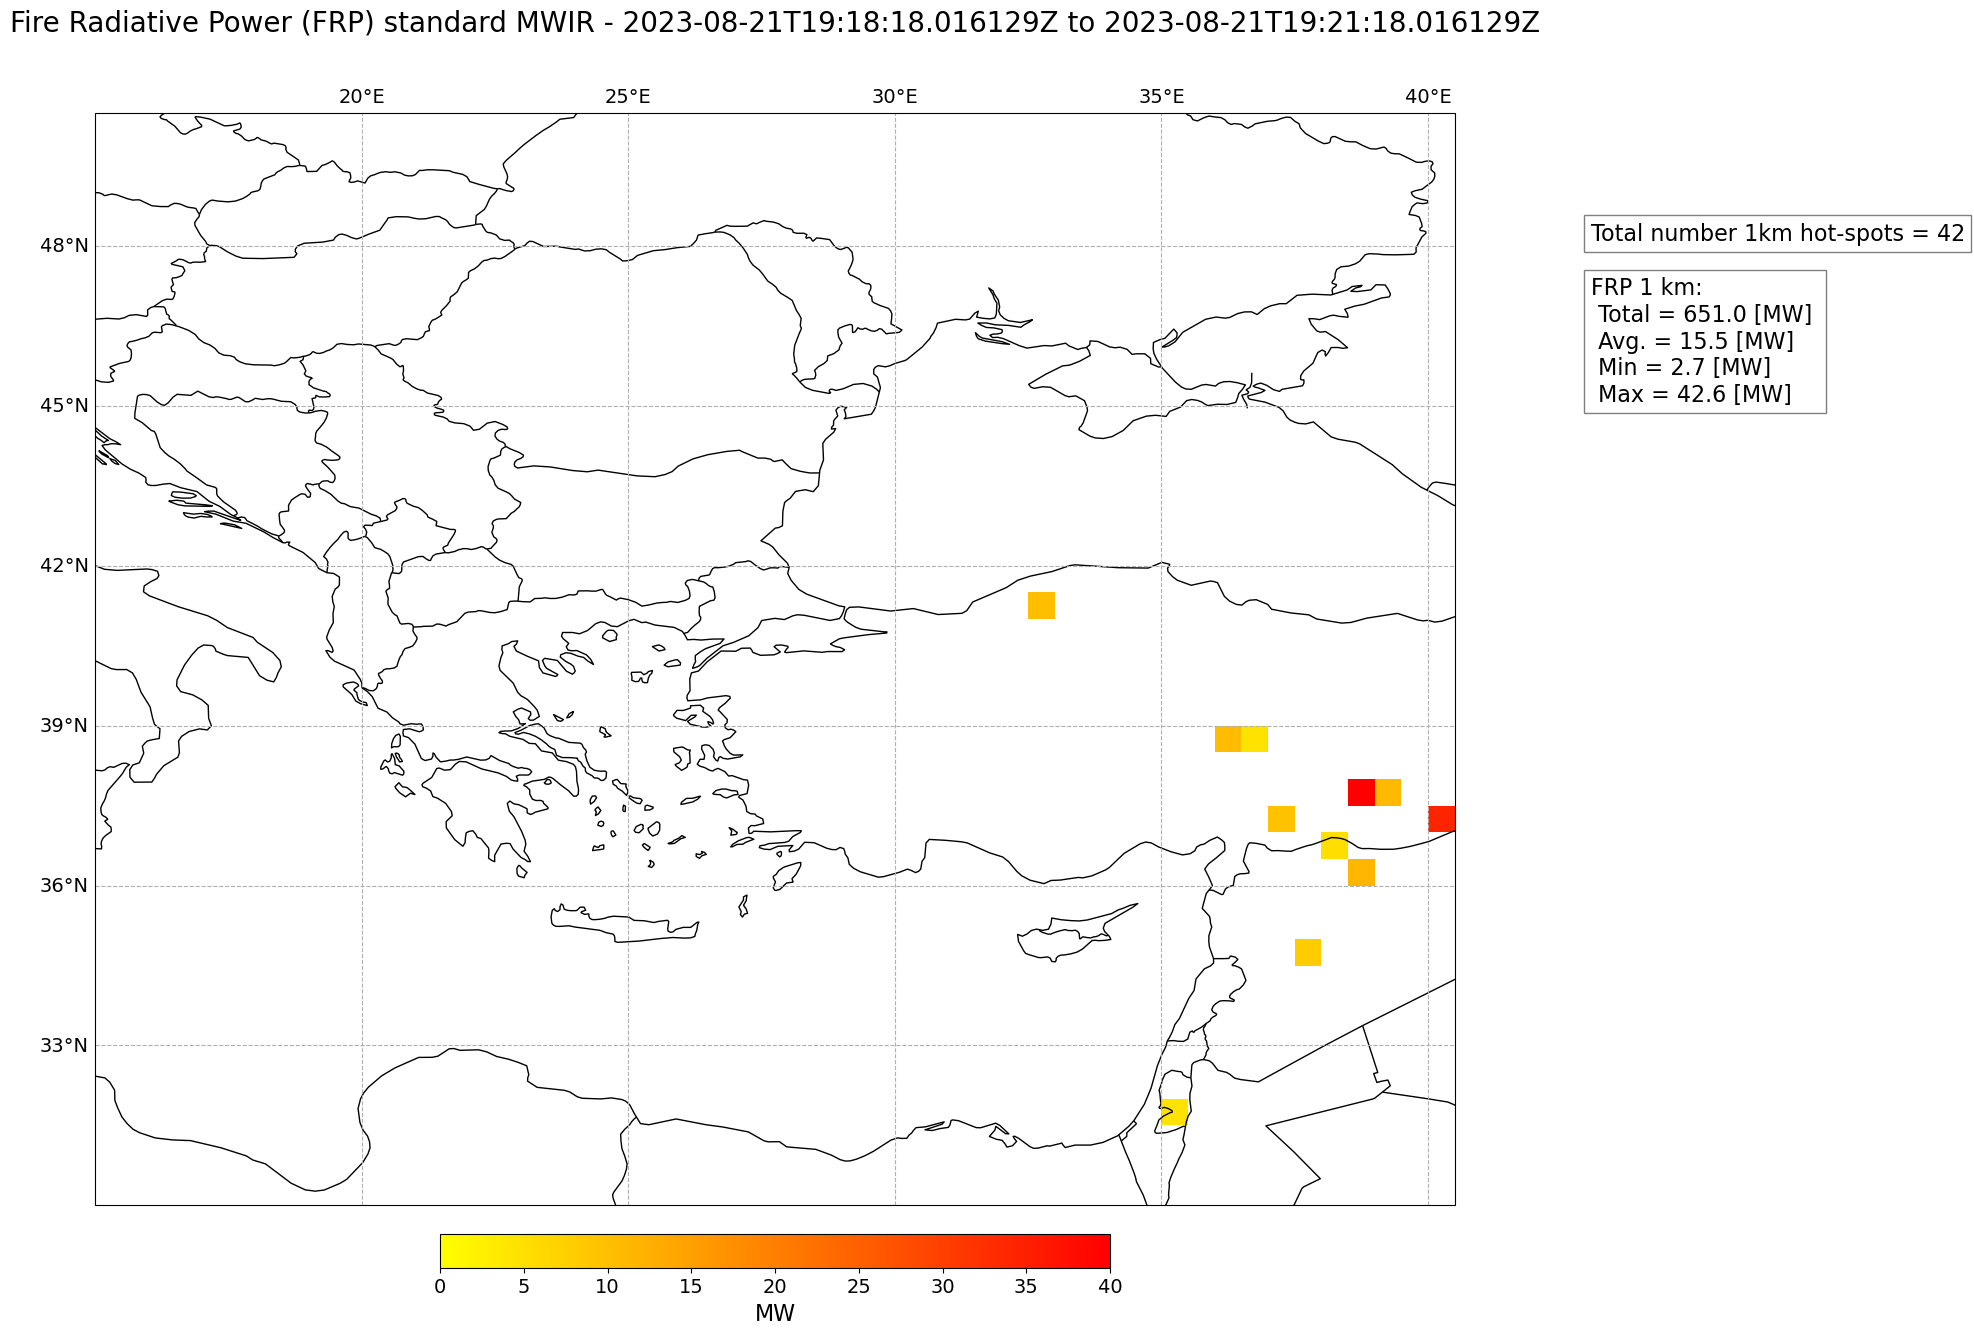

In [16]:
long_name = f"Fire Radiative Power (FRP) standard MWIR - {start_time} to {stop_time}"
unit = frp_mwir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(data=D_mwir[:,:],
                 lat=lat_grid, 
                 lon=lon_grid, 
                 unit=unit, 
                 longname=long_name, 
                 textstr_1=textstr_1, 
                 textstr_2=textstr_2, 
                 vmax=FRP_plot_max_grid)

<br>

Let us now repeat the processing steps above and let us process and visualize the `Fire Radiative Power computed from the SWIR channel`, which identifies fires with a temperature higher than 1100 Kelvin.

## <a id='load_swir'></a>Load, mask and regrid `FRP computed from the SWIR channel (2.25 um)`

Load the `FRP_SWIR` data variable from the loaded `netCDF` file.

In [17]:
frp_swir = frp_xr['FRP_SWIR']
frp_swir

<xarray.DataArray 'FRP_SWIR' (merged_MWIR1kmStandard_SWIR1km: 115)> Size: 460B
[115 values with dtype=float32]
Dimensions without coordinates: merged_MWIR1kmStandard_SWIR1km
Attributes:
    long_name:  Fire Radiative Power computed from SWIR channel (S6) - FRP SW...
    units:      MW

Filter only valid pixels and filter out all pixels that are `not equal to (!=)` -1. You see that a total of 1002 fires with a temperature higher than 1000 Kelvin were identified.

In [18]:
masked_frp_swir = generate_masked_array(frp_swir, frp_swir, -1., operator='!=', drop=True)
masked_frp_swir

<xarray.DataArray 'FRP_SWIR' (merged_MWIR1kmStandard_SWIR1km: 95)> Size: 380B
array([17.355076  ,  3.4341152 , 29.959436  ,  4.0277653 , 11.302817  ,
        7.8588767 ,  8.050187  ,  9.524882  , 66.47415   , 17.276361  ,
       18.932045  ,  3.6744354 , 16.198608  ,  3.905849  ,  4.1931286 ,
        6.023696  , 15.070305  , 19.04977   , 18.356646  ,  5.578112  ,
        4.4427977 ,  1.5344261 ,  0.51228994,  4.832582  ,  0.6076786 ,
        1.1643364 ,  1.1064144 ,  1.1794682 ,  1.0430694 ,  1.2792424 ,
        0.90167516,  2.091338  ,  8.033672  ,  6.431589  ,  3.6608055 ,
        7.8886366 , 10.689523  , 10.522035  , 11.625087  ,  4.3730273 ,
        5.933072  ,  5.225337  ,  5.8396983 ,  1.9974977 ,  8.476995  ,
       12.294634  ,  6.183223  , 13.625266  ,  6.550382  ,  4.413133  ,
       20.7153    ,  5.699986  ,  1.6111515 , 26.778826  ,  5.6049376 ,
        6.36029   , 13.623337  ,  4.944165  ,  4.8427405 ,  2.0247033 ,
       20.176128  , 18.493702  , 28.828934  ,  2.9017363 ,  8.683447  ,
        9.690287  ,  1.9216728 ,  2.3818736 ,  8.469453  ,  4.374084  ,
        5.935501  ,  1.4319609 ,  1.0045629 ,  0.93166965,  1.5321462 ,
        1.5043623 ,  0.8727271 ,  2.3893504 ,  2.5834103 ,  3.0415087 ,
        2.8481433 ,  2.560325  ,  1.1293788 ,  2.8899827 ,  1.8781537 ,
        1.2818359 ,  1.5855736 ,  0.5967456 ,  0.8103994 ,  0.8528424 ,
        2.003717  ,  0.9740151 ,  1.4323808 ,  0.9968579 ,  0.9335337 ],
      dtype=float32)
Dimensions without coordinates: merged_MWIR1kmStandard_SWIR1km
Attributes:
    long_name:  Fire Radiative Power computed from SWIR channel (S6) - FRP SW...
    units:      MW

Compute the number of total fires and per category.

In [19]:
n_fire_tot           = len(lat_frp[:])
n_fire_SWIR          = len(masked_frp_swir.to_masked_array().compressed())

n_fire_tot, n_fire_SWIR

(115, 95)


Apply the gridding function [slstr_frp_gridding](../functions.ipynb#slstr_frp_gridding) and bring the one-dimensional list of identified fire hotspots from the `SWIR channel` onto a regular-spaced grid.

In [20]:
FRP_SWIR_grid, lat_grid, lon_grid = slstr_frp_gridding(parameter_array=frp_swir, 
                                                       parameter='swir', 
                                                       lat_min=latmin, 
                                                       lat_max=latmax, 
                                                       lon_min=lonmin, 
                                                       lon_max=lonmax, 
                                                       sampling_lat_FRP_grid=sampling_lat_FRP_grid,
                                                       sampling_lon_FRP_grid=sampling_lon_FRP_grid, 
                                                       n_fire=n_fire_SWIR,
                                                       lat_frp=lat_frp,
                                                       lon_frp=lon_frp)

FRP_SWIR_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[30.25, 30.25, 30.25, ..., 30.25, 30.25, 30.25],
        [30.75, 30.75, 30.75, ..., 30.75, 30.75, 30.75],
        [31.25, 31.25, 31.25, ..., 31.25, 31.25, 31.25],
        ...,
        [49.25, 49.25, 49.25, ..., 49.25, 49.25, 49.25],
        [49.75, 49.75, 49.75, ..., 49.75, 49.75, 49.75],
        [50.25, 50.25, 50.25, ..., 50.25, 50.25, 50.25]], dtype=float32),
 array([[15.25, 15.75, 16.25, ..., 39.25, 39.75, 40.25],
        [15.25, 15.75, 16.25, ..., 39.25, 39.75, 40.25],
        [15.25, 15.75, 16.25, ..., 39.25, 39.75, 40.25],
        ...,
        [15.25, 15.75, 16.25,

Mask out all invalid pixels (pixels that are equal to -9999.) for plotting.

In [21]:
mask_valid = np.where(FRP_SWIR_grid[:,:] != -9999., False, True)
D_swir          = np.ma.masked_array(FRP_SWIR_grid[:,:], mask=mask_valid)

Calculate some statistics and add them to a string that can be integrated with the final plot.

In [22]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_SWIR)


FRP_sum      = np.sum(masked_frp_swir.to_masked_array().compressed())
FRP_mean     = np.mean(masked_frp_swir.to_masked_array().compressed())
FRP_std      = np.std(masked_frp_swir.to_masked_array().compressed())
FRP_min      = np.min(masked_frp_swir.to_masked_array().compressed())
FRP_max      = np.max(masked_frp_swir.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'

Apply the plotting function [visualize_s3_frp](../functions.ipynb#visualize_s3_frp) and make use of the attributes `units` and `long_name` provided by the data variable.

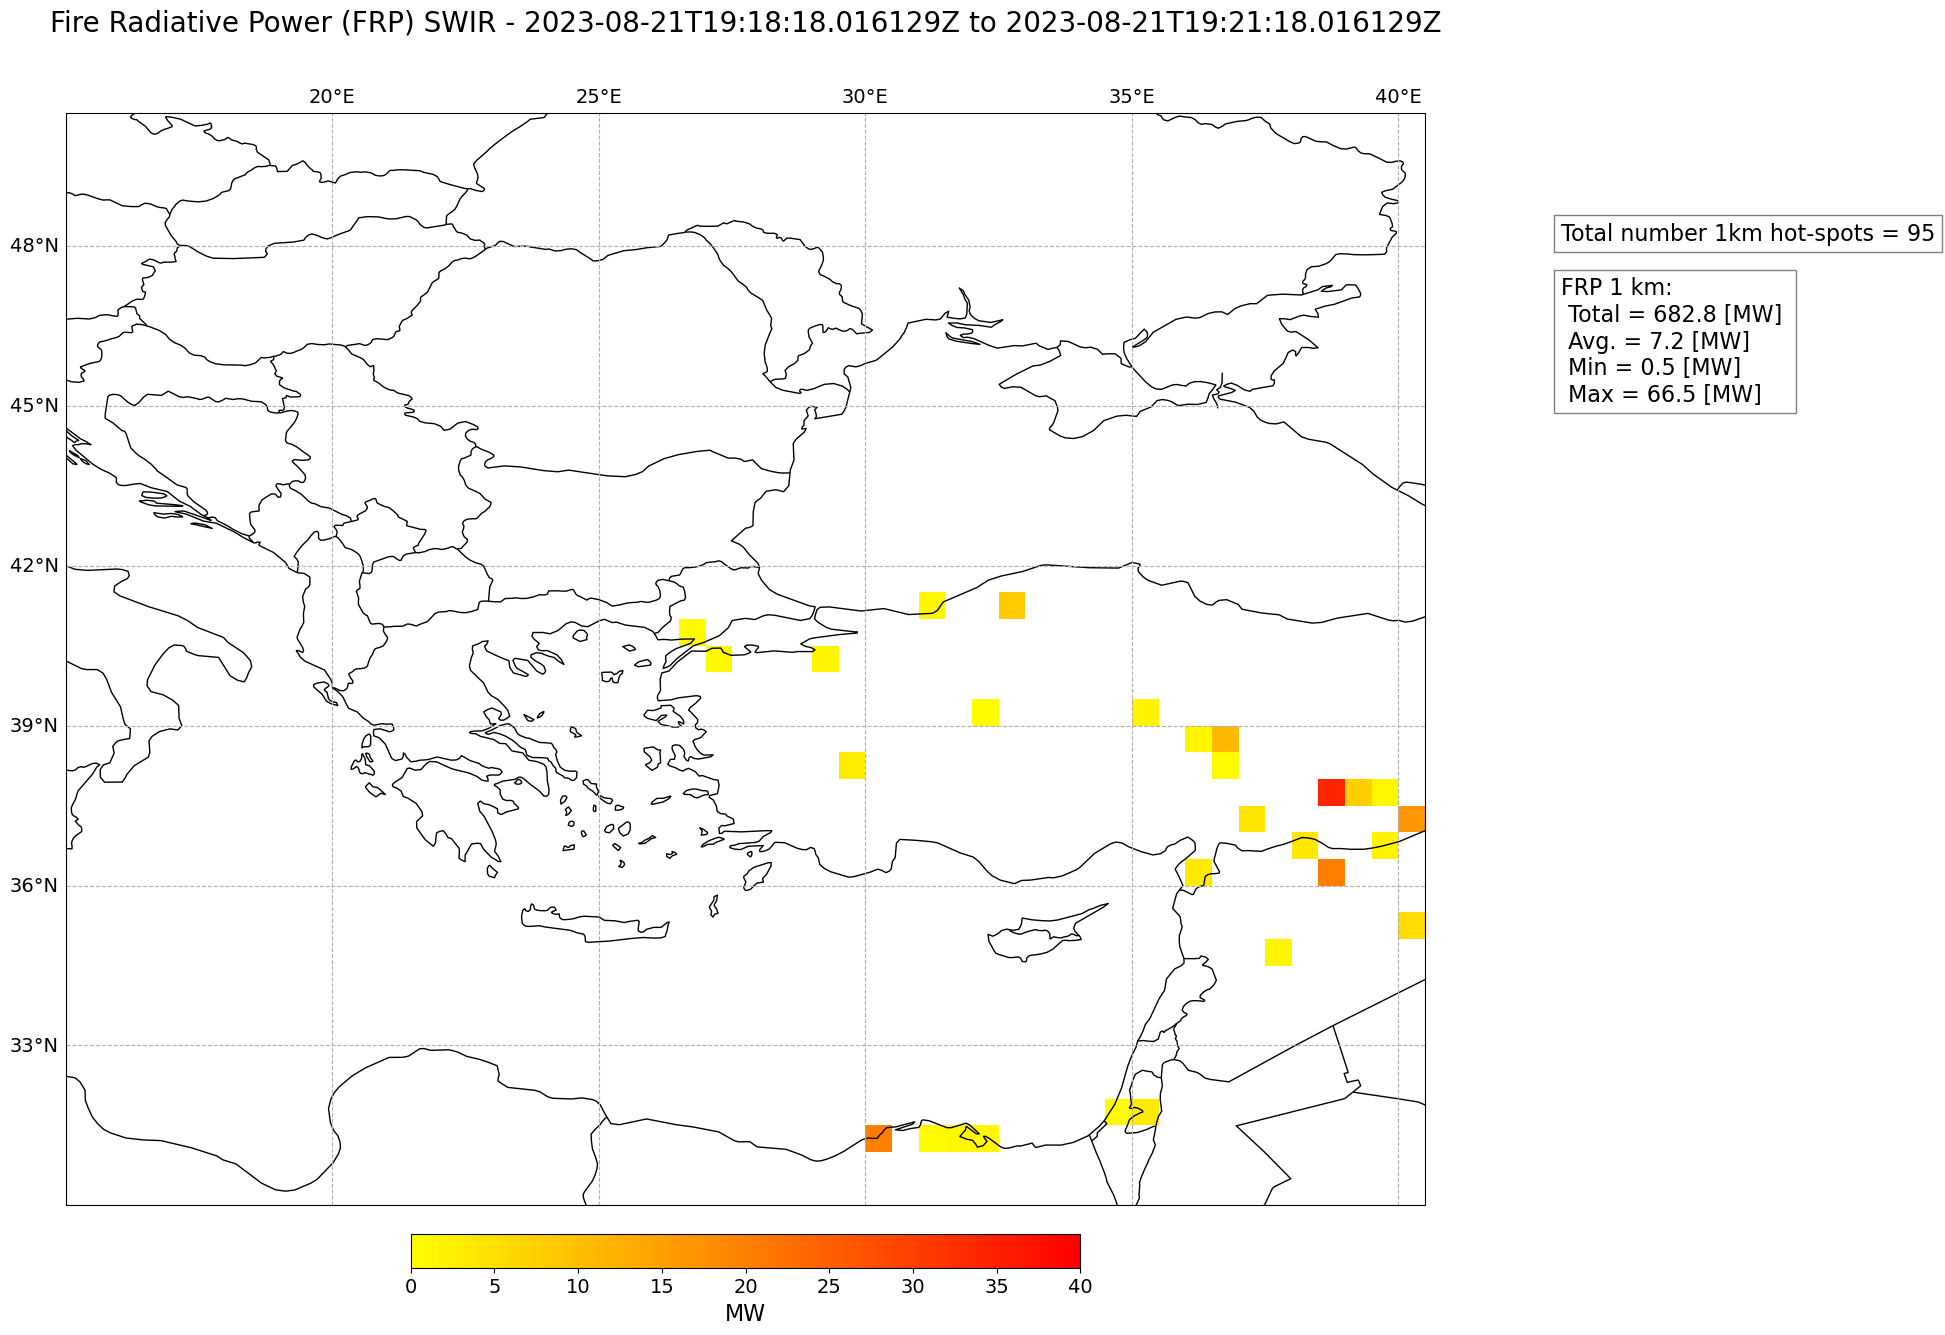

In [23]:
long_name = f"Fire Radiative Power (FRP) SWIR - {start_time} to {stop_time}"
unit = frp_swir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(data=D_swir[:,:],
                 lat=lat_grid, 
                 lon=lon_grid, 
                 unit=unit, 
                 longname=long_name, 
                 textstr_1=textstr_1, 
                 textstr_2=textstr_2, 
                 vmax=FRP_plot_max_grid)

### Additional informations

This notebook was adapted from: [https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/20_data_exploration/252_Sentinel-3_SLSTR_NRT_FRP_L2_load_browse.ipynb?ref_type=heads]( https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/20_data_exploration/252_Sentinel-3_SLSTR_NRT_FRP_L2_load_browse.ipynb?ref_type=heads)

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;">